<a href="https://colab.research.google.com/github/tensorflow-project/stable-diffusion/blob/own-textual/textual_inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-cv.git
!pip install -q tensorflow==2.11.0
!pip install pyyaml h5py

  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:


import math
import random

import keras_cv
import numpy as np
import tensorflow as tf
from keras_cv import layers as cv_layers
from keras_cv.models.stable_diffusion import NoiseScheduler
from tensorflow import keras
import matplotlib.pyplot as plt

stable_diffusion = keras_cv.models.StableDiffusion()

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
os.chdir("drive/MyDrive")
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)



Mounted at /content/drive


In [ ]:
def plot_images(images):
  """function to plot images in subplots"""
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [ ]:
def assemble_image_dataset(urls):
    """downloading the images we use for learning the new concept. For data preprocessing images are resized and normalized. 
    A dataset is created, shuffled and random noise is added to have a greater resemblance"""
  
    # Fetch all remote files
    files = [tf.keras.utils.get_file(origin=url) for url in urls]

    # Resize images
    resize = keras.layers.Resizing(height=512, width=512, crop_to_aspect_ratio=True)
    images = [keras.utils.load_img(img) for img in files]
    images = [keras.utils.img_to_array(img) for img in images]
    images = np.array([resize(img) for img in images])

    # The StableDiffusion image encoder requires images to be normalized to the [-1, 1] pixel value range
    images = images / 127.5 - 1

    # Create the tf.data.Dataset
    image_dataset = tf.data.Dataset.from_tensor_slices(images)

    # Shuffle and introduce random noise
    image_dataset = image_dataset.shuffle(50, reshuffle_each_iteration=True)
    image_dataset = image_dataset.map(
        cv_layers.RandomCropAndResize(
            target_size=(512, 512),
            crop_area_factor=(0.8, 1.0),
            aspect_ratio_factor=(1.0, 1.0),
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    image_dataset = image_dataset.map(
        cv_layers.RandomFlip(mode="horizontal"),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return image_dataset

In [ ]:
MAX_PROMPT_LENGTH = 77

### our new concept which is later inserted in the different prompts (for training and image generation)
placeholder_token = "<my-broccoli-token>"


def pad_embedding(embedding):
    ### pad the text embedding to have equal prompt length
    return embedding + (
        [stable_diffusion.tokenizer.end_of_text] * (MAX_PROMPT_LENGTH - len(embedding))
    )


stable_diffusion.tokenizer.add_tokens(placeholder_token)


def assemble_text_dataset(prompts):
    """ creates text dataset consisting of prompt embeddings"""
    ### inserts our placeholder_token into the different prompts
    prompts = [prompt.format(placeholder_token) for prompt in prompts]
    ### prompts are tokenized and encoded and then added to the embedding
    embeddings = [stable_diffusion.tokenizer.encode(prompt) for prompt in prompts]
    embeddings = [np.array(pad_embedding(embedding)) for embedding in embeddings]
    ### creates a dataset consisting of the different prompt embeddings and shuffles it
    text_dataset = tf.data.Dataset.from_tensor_slices(embeddings)
    text_dataset = text_dataset.shuffle(100, reshuffle_each_iteration=True)
    return text_dataset

1356917/1356917 [==============================] - 0s 0us/step


In [ ]:
def assemble_dataset(urls, prompts):
    """ zips the image dataset with the text dataset"""
    ### creating the image and test dataset
    image_dataset = assemble_image_dataset(urls)
    text_dataset = assemble_text_dataset(prompts)
    ###???
    # the image dataset is quite short, so we repeat it to match the length of the text prompt dataset
    image_dataset = image_dataset.repeat()

    # we use the text prompt dataset to determine the length of the dataset.  Due to the fact that there are relatively 
    # few prompts we repeat the dataset 5 times. We have found that this anecdotally improves results.
    text_dataset = text_dataset.repeat(5)
    return tf.data.Dataset.zip((image_dataset, text_dataset))

In [ ]:
### lists of the images and prompts we want to train the model on
train_ds = assemble_dataset(
    urls=[
        "https://i.imgur.com/Q8qiVEN.jpg",
        "https://i.imgur.com/uGkSrzg.jpg",
        #"https://i.imgur.com/OR2oxyK.jpg",
        #"https://i.imgur.com/9zAwPyt.jpg",

        "https://i.imgur.com/9ePHm21.jpg",
        "https://i.imgur.com/mZswnIx.jpg"

    ],
    prompts=[
        ### although we do not want a photo, https://arxiv.org/pdf/2208.01618.pdf states that this helps with target consistency
        "a photo of a {}",
        "a photo of {}",
        "a photo of one {}",
        "a photo of a nice {}",
        "a good photo of a {}",
        "a photo of the nice {}",
        "a photo of the small {}",
        "a photo of the weird {}",
        "a photo of the large {}",
        "a photo of a cool {}",
        "a photo of a small {}",
        "a rendition of the {}",
        "a nice sticker of a {}",
        "a sticker of a {}",
        "a sticker of {}",
        "a nice sticker of {}",
        "a telegram sticker of a {}",
        "a telegram sticker of {}",
        "a digital sticker of a {}",
        "a digital sticker of {}",
        "an emoji of a {}",
        "a {} emoji",
        "a digital {} sticker",
        "a {} telegram sticker",
        "a {} sticker",
        "a drawn {}",
        "a drawing of {}"
        "a {} in 2D",
        "a two dimensional {}",
        "a cartoon {}"
    ],
)

8784/8784 [==============================] - 0s 0us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
single_ds = assemble_dataset(
    urls=[
        "https://i.imgur.com/Q8qiVEN.jpg",
        "https://i.imgur.com/uGkSrzg.jpg",
        "https://i.imgur.com/OR2oxyK.jpg",
        "https://i.imgur.com/9zAwPyt.jpg"
    ],
    prompts=[
        "a photo of a {}",
        "a rendering of a {}",
        "a cropped photo of the {}",
        "the photo of a {}",
        "a photo of a clean {}",
        "a photo of my {}",
        "a photo of the cool {}",
        "a close-up photo of a {}",
        "a bright photo of the {}",
        "a cropped photo of a {}",
        "a photo of the {}",
        "a good photo of the {}",
        "a photo of one {}",
        "a close-up photo of the {}",
        "a rendition of the {}",
        "a photo of the clean {}",
        "a rendition of a {}",
        "a photo of a nice {}",
        "a good photo of a {}",
        "a photo of the nice {}",
        "a photo of the small {}",
        "a photo of the weird {}",
        "a photo of the large {}",
        "a photo of a cool {}",
        "a photo of a small {}",
    ],
)

In [ ]:


group_ds = assemble_dataset(
    urls=[
        "https://i.imgur.com/Q8qiVEN.jpg",
        "https://i.imgur.com/uGkSrzg.jpg",
        "https://i.imgur.com/OR2oxyK.jpg",
        "https://i.imgur.com/9zAwPyt.jpg",
        
    ],
    prompts=[
        "a photo of a group of {}",
        "a rendering of a group of {}",
        "a cropped photo of the group of {}",
        "the photo of a group of {}",
        "a photo of a clean group of {}",
        "a photo of my group of {}",
        "a photo of a cool group of {}",
        "a close-up photo of a group of {}",
        "a bright photo of the group of {}",
        "a cropped photo of a group of {}",
        "a photo of the group of {}",
        "a good photo of the group of {}",
        "a photo of one group of {}",
        "a close-up photo of the group of {}",
        "a rendition of the group of {}",
        "a photo of the clean group of {}",
        "a rendition of a group of {}",
        "a photo of a nice group of {}",
        "a good photo of a group of {}",
        "a photo of the nice group of {}",
        "a photo of the small group of {}",
        "a photo of the weird group of {}",
        "a photo of the large group of {}",
        "a photo of a cool group of {}",
        "a photo of a small group of {}",
    ],
)

In [ ]:
#train_ds = single_ds.concatenate(group_ds)
train_ds = train_ds.batch(1).shuffle(
    train_ds.cardinality(), reshuffle_each_iteration=True
)

In [ ]:
### defining concept we want to build our new concept on
tokenized_initializer = stable_diffusion.tokenizer.encode("broccoli")[1]
###??? - Mathis?
new_weights = stable_diffusion.text_encoder.layers[2].token_embedding(tf.constant(tokenized_initializer))

# Get len of .vocab instead of tokenizer
new_vocab_size = len(stable_diffusion.tokenizer.vocab)

# The embedding layer is the 2nd layer in the text encoder
old_token_weights = stable_diffusion.text_encoder.layers[2].token_embedding.get_weights()
old_position_weights = stable_diffusion.text_encoder.layers[2].position_embedding.get_weights()

old_token_weights = old_token_weights[0]
new_weights = np.expand_dims(new_weights, axis=0)
new_weights = np.concatenate([old_token_weights, new_weights], axis=0)

492466864/492466864 [==============================] - 2s 0us/step


In [ ]:
# Have to set download_weights False so we can initialize the weigths ourselves
### create a new text encoder 
new_encoder = keras_cv.models.stable_diffusion.TextEncoder(
    keras_cv.models.stable_diffusion.stable_diffusion.MAX_PROMPT_LENGTH,
    vocab_size=new_vocab_size,
    download_weights=False,
)
###???
for index, layer in enumerate(stable_diffusion.text_encoder.layers):
    # Layer 2 is the embedding layer, so we omit it from our weight-copying
    if index == 2:
        continue
    new_encoder.layers[index].set_weights(layer.get_weights())


new_encoder.layers[2].token_embedding.set_weights([new_weights])
new_encoder.layers[2].position_embedding.set_weights(old_position_weights)

stable_diffusion._text_encoder = new_encoder
stable_diffusion._text_encoder.compile(jit_compile=True)

In [ ]:
### we only train the encoder as we want to fine-tune the text embeddings
stable_diffusion.diffusion_model.trainable = False
stable_diffusion.decoder.trainable = False
stable_diffusion.text_encoder.trainable = True

stable_diffusion.text_encoder.layers[2].trainable = True

### defines a generator consisting of layers with specific attributes
def traverse_layers(layer):
    """yields layers with layer and embedding attributes"""
    if hasattr(layer, "layers"):
        for layer in layer.layers:
            yield layer
    if hasattr(layer, "token_embedding"):
        yield layer.token_embedding
    if hasattr(layer, "position_embedding"):
        yield layer.position_embedding

### iterates through the generator and adjusts the trainable attribute of the layers to trainable = True if it is part of the embedding
for layer in traverse_layers(stable_diffusion.text_encoder):
    if isinstance(layer, keras.layers.Embedding) or "clip_embedding" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

new_encoder.layers[2].position_embedding.trainable = False

198180272/198180272 [==============================] - 1s 0us/step


In [ ]:
### put all the different components of stable diff model into a list
all_models = [
    stable_diffusion.text_encoder,
    stable_diffusion.diffusion_model,
    stable_diffusion.decoder,
]

### check that only in the text encoder we have trainable weights
print([[w.shape for w in model.trainable_weights] for model in all_models])

[[TensorShape([49409, 768])], [], []]


In [ ]:
# Remove the top layer from the encoder, which cuts off the variance and only returns the mean
### due to simplicity?
### we use the image encoder to construct image embeddings out of the images we want to train on
training_image_encoder = keras.Model(
    stable_diffusion.image_encoder.input,
    stable_diffusion.image_encoder.layers[-2].output,
)


def sample_from_encoder_outputs(outputs):
    """ returns samples of the underlying embedding distribution """
    mean, logvar = tf.split(outputs, 2, axis=-1)
    logvar = tf.clip_by_value(logvar, -30.0, 20.0)
    std = tf.exp(0.5 * logvar)
    sample = tf.random.normal(tf.shape(mean))
    return mean + std * sample


def get_timestep_embedding(timestep, dim=320, max_period=10000):
    """ returns the embedding of a specific timestep in the denoising process"""
    #### Mathe???
    half = dim // 2
    freqs = tf.math.exp(
        -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
    )
    args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
    embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
    return embedding


def get_position_ids():
    """ returns a tensor containing all possible indices of a sequence"""
    return tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

136824240/136824240 [==============================] - 1s 0us/step


In [ ]:
class StableDiffusionFineTuner(keras.Model):
    def __init__(self, stable_diffusion, noise_scheduler, **kwargs):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        ### needed to calculate the amount of noise at a specific time step
        self.noise_scheduler = noise_scheduler

    def train_step(self, data):
        images, embeddings = data

        with tf.GradientTape() as tape:
            # Sample from the predicted distribution for the training image
            latents = sample_from_encoder_outputs(training_image_encoder(images))
            # The latents must be downsampled to match the scale of the latents used
            # in the training of StableDiffusion.  This number is truly just a "magic"
            # constant that they chose when training the model.
            latents = latents * 0.18215

            # Produce random noise in the same shape as the latent sample
            noise = tf.random.normal(tf.shape(latents))
            ### get the batch dimension
            batch_dim = tf.shape(latents)[0]

            # Pick a random timestep for each sample in the batch
            timesteps = tf.random.uniform(
                (batch_dim,),
                minval=0,
                maxval=noise_scheduler.train_timesteps,
                dtype=tf.int64,
            )

            # Add noise to the latents based on the timestep for each sample
            ### using the scheduler to determine the amount of noise
            noisy_latents = self.noise_scheduler.add_noise(latents, noise, timesteps)

            # Encode the text in the training samples to use as hidden state in the diffusion model
            ### hidden state here means the output of the text encoder, thus the text embedding of our prompts
            encoder_hidden_state = self.stable_diffusion.text_encoder(
                [embeddings, get_position_ids()]
            )

            # Compute timestep embeddings for the randomly-selected timesteps for each sample in the batch
            timestep_embeddings = tf.map_fn(
                fn=get_timestep_embedding,
                elems=timesteps,
                fn_output_signature=tf.float32,
            )

            # Call the diffusion model
            ### calculate the noise predictions for each pixel(?)
            noise_pred = self.stable_diffusion.diffusion_model(
                [noisy_latents, timestep_embeddings, encoder_hidden_state]
            )

            # Compute the mean-squared error loss and reduce it
            ### by taking the mean
            loss = self.compiled_loss(noise_pred, noise)
            loss = tf.reduce_mean(loss, axis=2)
            loss = tf.reduce_mean(loss, axis=1)
            loss = tf.reduce_mean(loss)

        # Load the trainable weights and compute the gradients for them
        trainable_weights = self.stable_diffusion.text_encoder.trainable_weights
        grads = tape.gradient(loss, trainable_weights)

        # Gradients are stored in indexed slices, so we have to find the index
        # of the slice(s) which contain the placeholder token.
        index_of_placeholder_token = tf.reshape(tf.where(grads[0].indices == 49408), ())
        condition = grads[0].indices == 49408
        condition = tf.expand_dims(condition, axis=-1)

        # Override the gradients, zeroing out the gradients for all slices that
        # aren't for the placeholder token, effectively freezing the weights for
        # all other tokens.
        grads[0] = tf.IndexedSlices(
            values=tf.where(condition, grads[0].values, 0),
            indices=grads[0].indices,
            dense_shape=grads[0].dense_shape,
        )

        self.optimizer.apply_gradients(zip(grads, trainable_weights))
        return {"loss": loss}

In [ ]:
def textual_inversion(model, noise_scheduler, data):

    images, prompt_embeddings = data

    with tf.GradientTape() as tape:
        ### creating embeddings out of the images 
        image_embeddings = training_image_encoder(images)
        ### pass the embeddings to the sampler and save some sammples in latents
        latents = sample_from_encoder_outputs(image_embeddings)
        ### match the latents with those used in the training of Stable Diffusion (just a random number they used in the training)
        latents = latents * 0.18215

        ### random noise in the same shape as latents
        noise = tf.random.normal(tf.shape(latents))
        
        ### get the batch dimension of our input data
        batch_dim = tf.shape(latents)[0]

        ### for each sample in the batch we choose a different random timestep to later determine the specific timestep embedding
        timesteps = tf.random.uniform(batch_dim,), minval=0, maxval=noise_scheduler.train_timesteps, dtype=tf.int64,)


        ### add the noise corresponding to the timestep to the latents by use of the scheduler
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
        
        ### tensor containing all possible indices
        indices = get_position_ids()
        
        ### calculate the output of the encoder
        output_encoder = model.text_encoder([prompt_embeddings, indices])
        
        ### getting the timestep embeddings for each timestep
        timestep_embeddings = tf.map_fn(fn=get_timestep_embedding, elems=timesteps, fn_output_signature=tf.float32,)

        ### ???
        noise_pred = model.diffusion_model([noisy_latents, timestep_embeddings, output_encoder])

        ### compute the mean squared error between the noise and the predicted noise and reduce it by taking the mean
        loss = tf.keras.losses.mean_squared_error(noise_pred, noise)
        loss = tf.reduce_mean(loss, axis=2)
        loss = tf.reduce_mean(loss, axis=1)
        loss = tf.reduce_mean(loss)

        ### load the the weights we want to train from the text encoder and calculate the gradients for them
        trainable_weights = model.text_encoder.trainable_weights
        gradients = tape.gradient(loss, trainable_weights)

        #index_of_placeholder_token = tf.reshape(tf.where(gradients[0].indices == 49408), ())

        ### we only want to update the gradient of the placeholder token, therefore we create the tensor condition which has the value true for the index of the placeholder token (49408) and otherwise false
        condition = gradients[0].indices == 49408

        ### add an extra dimension to later zero out the gradients for other tokens
        condition = tf.expand_dims(condition, axis=-1)

        ### freeze the weights for all tokens by setting the gradients to 0 except for the placeholder token
        gradients[0] = tf.IndexedSlices(values=tf.where(condition, gradients[0].values,0), indices=gradients[0].indices, dense_shape=gradients[0].dense_shape)

        ### apply the gradients to the trainable weights of the encoder and thus only training the placeholder token's embedding
        optimizer.apply_gradients(zip(gradients, trainable_weights))

        return {"loss": loss}

50/50 [==============================] - 139s 2s/step


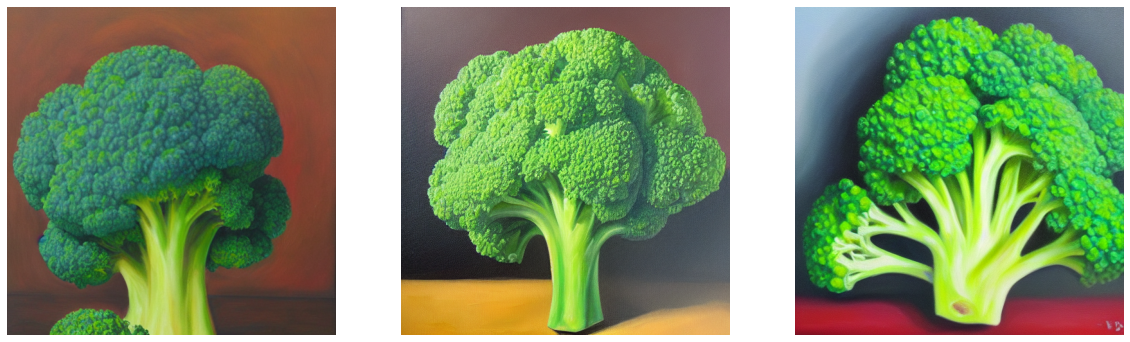

In [ ]:
generated = stable_diffusion.text_to_image(
    f"an oil painting of {placeholder_token}", seed=1337, batch_size=3
)
plot_images(generated)

In [ ]:
### beta is the diffusion rate (what does it do exactly?)
noise_scheduler = NoiseScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    train_timesteps=1000,
)

### Initialize the model we use to fine tune our concept
trainer = StableDiffusionFineTuner(stable_diffusion, noise_scheduler, name="trainer")
EPOCHS = 3
### learning rate decays depending on the number of epochs to avoid convergence issues in few epochs (?)
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=train_ds.cardinality() * EPOCHS
)
### inizialize the optimizer
optimizer = keras.optimizers.Adam(
    weight_decay=0.004, learning_rate=learning_rate, epsilon=1e-8, global_clipnorm=10
)

trainer.compile(
    optimizer=optimizer,
    # We are performing reduction manually in our train step, so none is required here.
    loss=keras.losses.MeanSquaredError(reduction="none"),
)

In [ ]:
class GenerateImages(keras.callbacks.Callback):
    def __init__(
        self, stable_diffusion, prompt, steps=50, frequency=10, seed=None, **kwargs
    ):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        self.prompt = prompt
        self.seed = seed
        self.frequency = frequency
        self.steps = steps

    def on_epoch_end(self, epoch, logs):
        if epoch % self.frequency == 0:
            images = self.stable_diffusion.text_to_image(
                self.prompt, batch_size=3, num_steps=self.steps, seed=self.seed
            )
            plot_images(
                images,
            )

### to see the progress within the training
cbs = [
    GenerateImages(
        stable_diffusion, prompt=f"an oil painting of {placeholder_token}", seed=1337
    ),
    GenerateImages(
        stable_diffusion, prompt=f"gandalf the gray as a {placeholder_token}", seed=1337
    ),
    GenerateImages(
        stable_diffusion,
        prompt=f"two {placeholder_token} getting married, photorealistic, high quality",
        seed=1337,
    ),
]

In [ ]:
### define where we save our weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



In [ ]:
### load saved weights
trainer.load_weights(checkpoint_path)

In [ ]:

### the actual training


trainer.fit(
    train_ds,
    epochs=EPOCHS,
    #callbacks=cbs,
    callbacks=[cp_callback]
)

os.listdir(checkpoint_dir)


Epoch 1/3
44/98 [============>.................] - ETA: 1:26 - loss: 0.1009

50/50 [==============================] - 124s 2s/step


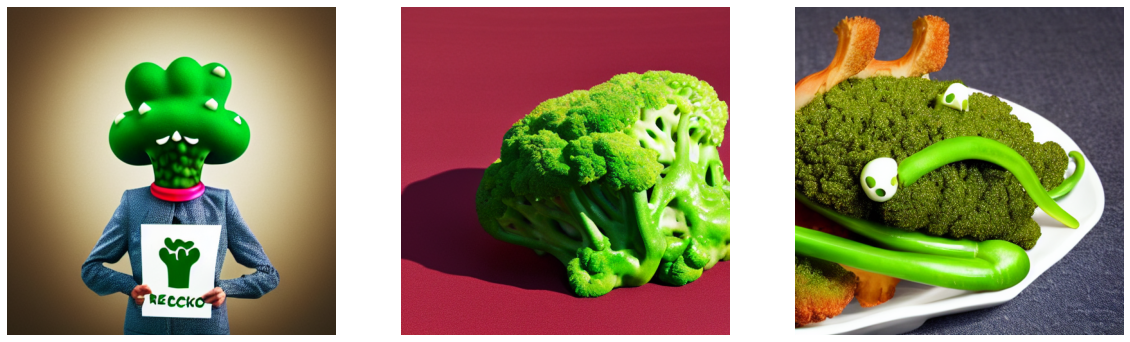

In [ ]:
### generate some examples and plot them according to our new concept and prompts
generated = stable_diffusion.text_to_image(
    f"a photo of a {placeholder_token} ",
    batch_size=3,
)
plot_images(generated)

50/50 [==============================] - 124s 2s/step


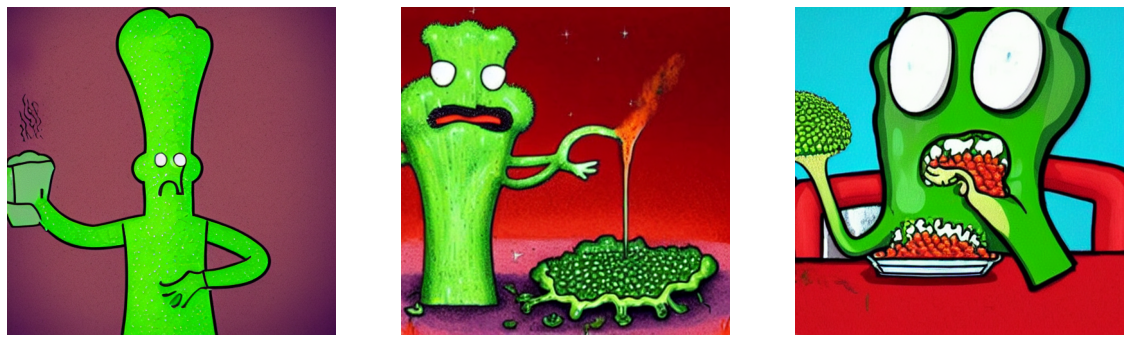

In [ ]:
generated = stable_diffusion.text_to_image(
    f"A masterpiece of a {placeholder_token} crying out to the heavens. "
    f"Behind the {placeholder_token}, an dark, evil shade looms over it - sucking the "
    "life right out of it.",
    batch_size=3,
)
plot_images(generated)

50/50 [==============================] - 123s 2s/step


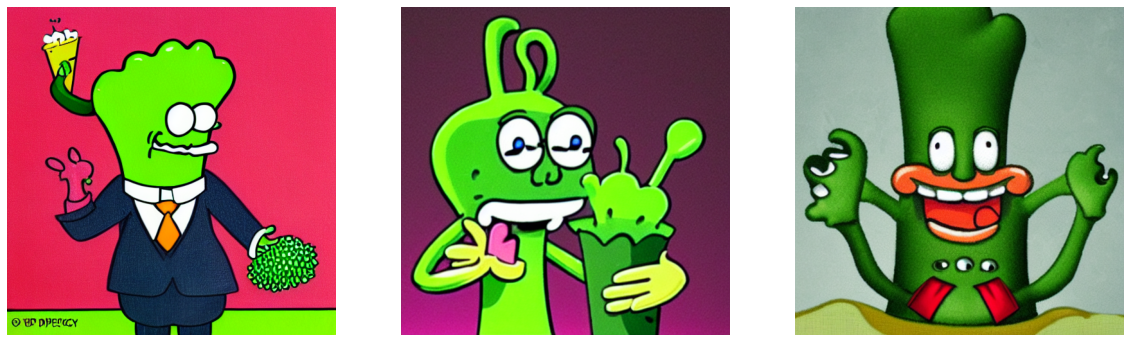

In [ ]:
generated = stable_diffusion.text_to_image(
    f" a happy {placeholder_token}.", batch_size=3
)
plot_images(generated)


50/50 [==============================] - 124s 2s/step


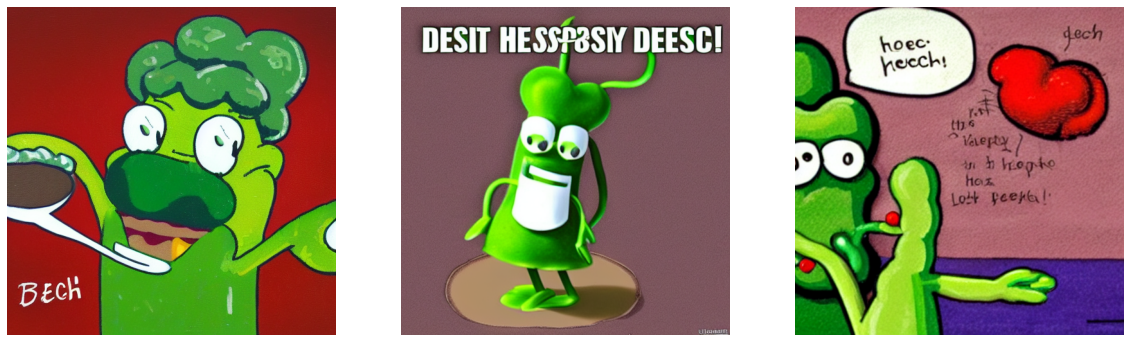

In [ ]:
generated = stable_diffusion.text_to_image(
    f" a desperate {placeholder_token}.", batch_size=3
)
plot_images(generated)


50/50 [==============================] - 124s 2s/step


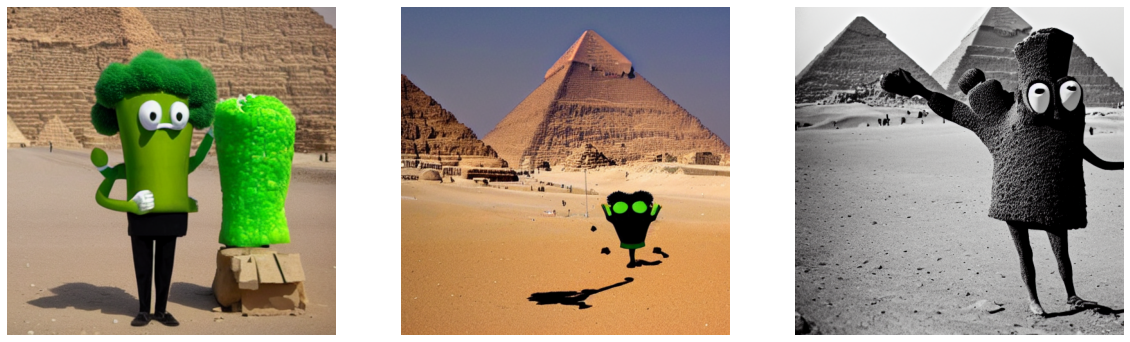

In [ ]:
generated = stable_diffusion.text_to_image(
    f"A mysterious {placeholder_token} approaches the great pyramids of egypt.",
    batch_size=3,
)
plot_images(generated)

In [ ]:
generated = stable_diffusion.text_to_image(
    f"a sticker of a happy broccoli", seed=1337, batch_size=3
)
plot_images(generated)